# **Depth and Contact Prediction**

## Objective

In this project we want to use deep neural networks to predict 3D contact geometry from monocular images of a vision-based tactile sensor.

# Background

  - **Tactile sensors** are devices designed to measure information arising from the physical interaction of robots with their environment. These sensors excel in detecting stimuli resulting from mechanical stimulation, temperature variations, and even pain-like responses.
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1dBNV2bzJVY4bS70TljKFSjzn7X40vY70" alt="Digit on allgero" width="450"/>
</p>
However, recent sensor developments in this field, often inspired by the biological sense of cutaneous touch, have predominantly concentrated on capturing the 3D geometry of contact. In this project, we aim to extend this focus to predicting such interactions, particularly for GelSight tactile sensors. The figure below illustrates the resolution of tactile sensors when they come into contact with various objects
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1JtePPB9wisU5XdIZ56P_Omo_84QZmFGk" alt="Digit images"/>
</p>
The papers below contain crucial information on how these sensors work, which could be helpful for success in this project <br>
<a href="http://gelsight.csail.mit.edu/wedge/ICRA2021_Wedge.pdf"> GelSight Wedge: Measuring High-Resolution 3D Contact Geometry with a Compact Robot Finger</a><br>
<a href="https://arxiv.org/pdf/2005.14679.pdf">DIGIT: A Novel Design for a Low-Cost Compact
High-Resolution Tactile Sensor with Application to
In-Hand Manipulation</a>

- **Depth Prediction** is the task of measuring the distance of each pixel relative to the camera. Depth is extracted from either monocular (single) or stereo (multiple views of a scene) images. Traditional methods use multi-view geometry to find the relationship between the images. Newer methods can directly estimate depth by minimizing the regression loss, or by learning to generate a novel view from a sequence. *You can also watch one of the recent works in PRG on reconstructing objects with tactile sensors on [YouTube](https://www.youtube.com/watch?v=38utg590wao)*.


## Objective
In this project, we aim to acquire the inverse sensor model to reconstruct local 3D geometry from a tactile image. The task involves training the model in a supervised manner to predict local heightmaps and contact areas from tactile images. While one potential strategy involves integrating depth and contact prediction within a stacked neural network, such as outlined in [Depth Map Prediction from a Single Image using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf), we encourage you to propose a novel approach tailored to the specific challenges of the problem. Nevertheless, we'll provide you with a project template to guide your implementation, building upon the principles covered during semester.

**IN THIS PROJECT ALL FUNCTIONS/LIBRARIES ARE ALLOWED**

### Step 1: Dataloading
Create a custom dataset to read images from the [provided dataset](). For guidance, refer to the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time
import os
import re
import tqdm
from tqdm import tqdm
import random
from imageio import imread
from pathlib import Path
from PIL import Image, ImageFile
import zipfile
import requests
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
 # Download the dataset
!wget https://shorturl.at/ayEOY
!unzip ayEOY

In [ ]:
print(os.getcwd())  # Print current working directory
print(os.listdir())  # List contents of the current directory

/content
['.config', 'ayEOY', 'mini_depth_dataset', 'ayEOY.1', 'sample_data']


In [ ]:
# Replace 'path_to_your_directory' with the actual path
path_to_your_directory = '/content/mini_depth_dataset'

# Function to print directory structure recursively
def print_directory_structure(path, indent=''):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isfile(item_path):
            print(indent + '|--', item)  # Print files
        elif os.path.isdir(item_path):
            print(indent + '|--', item)  # Print directories
            print_directory_structure(item_path, indent + '    ')  # Recursively print directory contents

print_directory_structure(path_to_your_directory)

In [ ]:
class TactileDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super(TactileDataset, self).__init__()

        self.data_dir = data_dir
        self.transform = transform

        self.folders = [
            'digit_mount', 'cables', 'cube', 'long_cylinder', 'ring', 'big_decagon', 'med_decagon', 'hafez'
        ]

        self.depth_files = []
        self.tactile_files = []
        for folder in self.folders:
            depth_path = os.path.join(self.data_dir, folder, 'depth')
            tactile_path = os.path.join(self.data_dir, folder, 'tactile')

            self.depth_files.extend([os.path.join(depth_path, f) for f in os.listdir(depth_path)])
            self.tactile_files.extend([os.path.join(tactile_path, f) for f in os.listdir(tactile_path)])

    def __len__(self):
        return min(len(self.depth_files), len(self.tactile_files))  # Assuming depth and tactile files have the same length

    def __getitem__(self, idx):
        if idx >= len(self):
          raise IndexError("Index out of range")

        depth_sample = Image.open(self.depth_files[idx]).convert('RGB')
        tactile_sample = Image.open(self.tactile_files[idx]).convert('RGB')

        # Calculate contact mask based on depth
        depth_array = np.array(depth_sample)
        contact_array = (depth_array[:, :, 0] > 0).astype(np.uint8) * 255  # depth greater than 0 represents contact

        # Create an image from the contact array
        contact_sample = Image.fromarray(contact_array, mode='L')  # 'L' for grayscale

        # transformations
        if self.transform:
            seed = random.randint(0, 2 ** 32)
            random.seed(seed)
            depth_sample = self.transform(depth_sample)
            random.seed(seed)
            tactile_sample = self.transform(tactile_sample)

            contact_sample = self.transform(contact_sample)  # Apply the same transform

        sample = {'tactile': tactile_sample, 'depth': depth_sample, 'contact': contact_sample}

        return sample

# Paths to your dataset
data_dir = '/content/mini_depth_dataset'  # Adjust based on your working directory

# transformations for training and validation
trans_train = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor(),
])

# Create dataset
dataset = TactileDataset(data_dir, transform=trans_train)

# Split the dataset into train and validation sets
train_idx, valid_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

dataset_train = torch.utils.data.Subset(dataset, train_idx)
dataset_valid = torch.utils.data.Subset(dataset, valid_idx)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)

datalen_train = len(dataset_train)
datalen_valid = len(dataset_valid)
print(datalen_train, datalen_valid)

812 203


In [ ]:
#  Check shape and number of Channels
for i, samples in enumerate(dataloader_train):
    depth_sample = samples['depth']
    print(f"Depth image shape: {depth_sample.shape}")
    # Check number of channels in the depth images
    num_channels = depth_sample.size(1)
    print(f"Number of channels in depth images: {num_channels}")


    tactile_sample = samples['tactile']
    print(f"tactile image shape: {tactile_sample.shape}")
    # Check number of channels in the depth images
    num_channels = tactile_sample.size(1)
    print(f"Number of channels in tactile images: {num_channels}")
    # Break after examining one batch
    break

Depth image shape: torch.Size([32, 3, 240, 320])
Number of channels in depth images: 3
tactile image shape: torch.Size([32, 3, 240, 320])
Number of channels in tactile images: 3


#Visualizing how transform is affecting the image

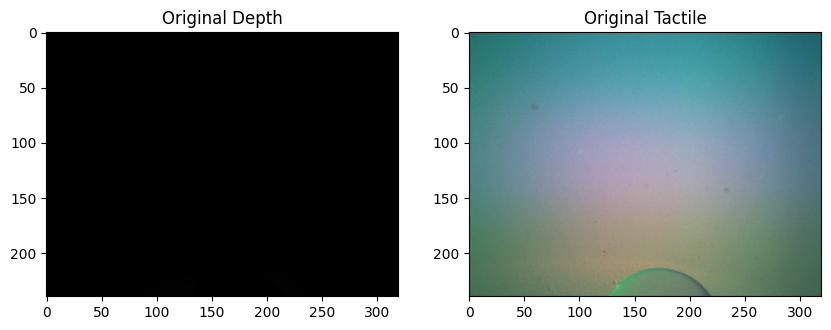

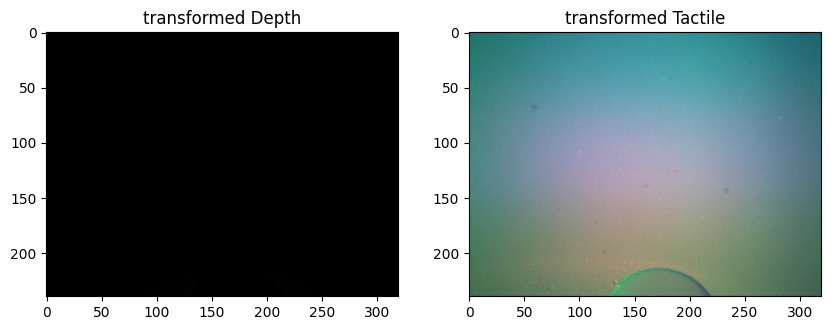

In [ ]:
#a random sample index
idx = random.randint(0, len(dataset) - 1)

#sample from the dataset
sample = dataset[idx]

# Extract the images
depth_sample = sample['depth']
tactile_sample = sample['tactile']

# Display original images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(depth_sample.permute(1, 2, 0))  # tensor is in (C, H, W) format
axs[0].set_title('Original Depth')

axs[1].imshow(tactile_sample.permute(1, 2, 0))  # tensor is in (C, H, W) format
axs[1].set_title('Original Tactile')

dataset = TactileDataset(data_dir, transform=trans_train)
transformed = dataset[idx]
contact_image = dataset[idx]

depth_transformed = transformed['depth']
tactile_transformed = transformed['tactile']
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(TF.to_pil_image(depth_transformed))  # tensor is in (C, H, W) format
axs[0].set_title('transformed Depth')

axs[1].imshow(TF.to_pil_image(tactile_transformed))  # tensor is in (C, H, W) format
axs[1].set_title('transformed Tactile')

plt.show()

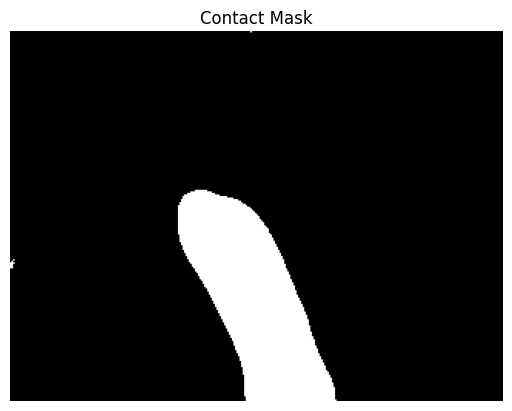

Contact image shape: torch.Size([1, 240, 320])
Number of channels in contact image: 1


In [ ]:
#  visualize the contact mask
def visualize_contact(contact_sample):
    plt.imshow(contact_sample.squeeze(0), cmap='gray')  # contact_sample is a tensor
    plt.title('Contact Mask')
    plt.axis('off')
    plt.show()

# Displaying contact mask for a sample
sample = dataset_train[16]
contact_sample = sample['contact']
visualize_contact(contact_sample)

#shape and number of channels of the contact sample
print(f"Contact image shape: {contact_sample.shape}")
num_channels = contact_sample.size(0)
print(f"Number of channels in contact image: {num_channels}")

In [ ]:
# Inspect content of train_loader
for batch_idx, sample_batch in enumerate(dataloader_train):
    print(f"Batch {batch_idx + 1} content:")
    #print(sample_batch)
    # Access specific keys in the batch to see their content
    # For example:
    print(sample_batch['tactile'])  # To view tactile images
    print(sample_batch['depth'])
    #print(sample_batch['contact']) #it has no images   # To view labels

    if batch_idx == 0:  # Viewing the content of the first batch only
        break

Batch 1 content:
tensor([[[[0.1333, 0.1373, 0.1451,  ..., 0.1373, 0.1294, 0.1294],
          [0.1255, 0.1333, 0.1451,  ..., 0.1255, 0.1333, 0.1137],
          [0.1451, 0.1569, 0.1451,  ..., 0.1216, 0.1176, 0.1294],
          ...,
          [0.2353, 0.2588, 0.2510,  ..., 0.2314, 0.2353, 0.2353],
          [0.2235, 0.2510, 0.2353,  ..., 0.2353, 0.2314, 0.2392],
          [0.2471, 0.2314, 0.2275,  ..., 0.2471, 0.2431, 0.2431]],

         [[0.4471, 0.4431, 0.4353,  ..., 0.4039, 0.4039, 0.3882],
          [0.4471, 0.4353, 0.4431,  ..., 0.4039, 0.3922, 0.4039],
          [0.4549, 0.4471, 0.4471,  ..., 0.3922, 0.4039, 0.3922],
          ...,
          [0.4235, 0.4196, 0.4196,  ..., 0.3765, 0.3804, 0.3843],
          [0.4275, 0.4235, 0.4196,  ..., 0.3686, 0.3765, 0.3725],
          [0.4235, 0.4196, 0.4235,  ..., 0.3725, 0.3725, 0.3725]],

         [[0.4118, 0.4118, 0.4000,  ..., 0.4196, 0.4118, 0.4431],
          [0.4078, 0.3922, 0.4118,  ..., 0.4275, 0.4235, 0.4157],
          [0.4196, 0.4196

### Step 2: Network Design
Design the neural network, incorporating various [layers](https://pytorch.org/docs/stable/nn.html). Additionally, consider initializing the layer weights using predefined [PyTorch initializers](https://pytorch.org/docs/stable/nn.init.html). Inpired by [1], you may use Coarse network for contact prediction and a Fine network for depth prediction, providing higher resolution.
<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1_IJxSfYNjsU6wkE0QwSMF4LSvENuJPRL" alt="Digit images"/>
</p>


In [ ]:
class ContactNet(nn.Module):
    def __init__(self, init=True):
        super(ContactNet, self).__init__()
        # network layers for contact prediction
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)  # Final layer to match target shape

        if init:
            # Initialize weights
            init.xavier_normal_(self.conv1.weight)
            init.xavier_normal_(self.conv2.weight)
            init.xavier_normal_(self.final_conv.weight)

    def forward(self, x):
        # Forward pass for contact prediction
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        c = torch.sigmoid(self.final_conv(x))  # Use sigmoid for binary classification
        return c

In [ ]:
class TactileDepthNet(nn.Module):
    def __init__(self, init=True):
        super(TactileDepthNet, self).__init__()
        # layers for tactile data
        self.tactile_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.tactile_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.tactile_fc_input_size = 64 * 240 * 320  # Calculate the flattened size for tactile data

        # layers for depth data
        self.depth_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.depth_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.depth_fc_input_size = 64 * 240 * 320  # Calculate the flattened size for depth data

        # Combined fully connected layers
        self.fc_combined_input_size = self.tactile_fc_input_size + self.depth_fc_input_size
        self.fc_combined = nn.Linear(self.fc_combined_input_size, 1)  # Outputting a single depth prediction

        if init:
            # Initialize weights for tactile layers
            init.xavier_normal_(self.tactile_conv1.weight)
            init.xavier_normal_(self.tactile_conv2.weight)
            # Initialize weights for depth layers
            init.xavier_normal_(self.depth_conv1.weight)
            init.xavier_normal_(self.depth_conv2.weight)
            # Initialize weights for combined fully connected layers
            init.xavier_normal_(self.fc_combined.weight)

    def forward(self, tactile_input, depth_input):
        # Forward pass for tactile data
        x1 = nn.functional.relu(self.tactile_conv1(tactile_input))
        x1 = nn.functional.relu(self.tactile_conv2(x1))
        x1 = x1.view(x1.size(0), -1)  # Flatten for fully connected layer for tactile data

        # Forward pass for depth data
        x2 = nn.functional.relu(self.depth_conv1(depth_input))
        x2 = nn.functional.relu(self.depth_conv2(x2))
        x2 = x2.view(x2.size(0), -1)  # Flatten for fully connected layer for depth data

        # Concatenate flattened tensors from both modalities
        combined = torch.cat((x1, x2), dim=1)  # Concatenate along the feature dimension

        # Combined fully connected layers
        d = self.fc_combined(combined)  # Output depth prediction

        return d.squeeze(1)  # Squeeze to return a single value

In [ ]:
# initialize
contact_model = ContactNet(init=False).to(device)
tactile_depth_model = TactileDepthNet(init=False).to(device)

### Step 3: Loss Function


In [ ]:
class Loss(nn.Module):
  def __init__(self,task):
        super(Loss, self).__init__()

        self.task = task

  def forward(self, pred, target):
        if self.task == 'contact':
            criterion = nn.BCEWithLogitsLoss()(pred, target)

        elif self.task == 'tactile_depth':
            criterion = F.mse_loss(pred, target)

        else:
            raise ValueError("Unknown task. Please specify 'contact' or 'tactile_depth'.")

        return criterion
#criterion
contact_criterion = Loss(task='contact')
tactile_depth_criterion = Loss(task='tactile_depth')


# Apply DataParallel to the models
if torch.cuda.device_count() > 1:
    contact_model = nn.DataParallel(contact_model)
    tactile_depth_model = nn.DataParallel(tactile_depth_model)



# Set different learning rates for different parts of the model
contact_optimizer = torch.optim.Adam([
    {'params': contact_model.conv1.parameters(), 'lr': 0.001},
    {'params': contact_model.conv2.parameters(), 'lr': 0.001},
    {'params': contact_model.final_conv.parameters(), 'lr': 0.001},
], lr=0.001)
tactile_depth_optimizer = torch.optim.Adam(tactile_depth_model.parameters(), lr=0.001)

In [ ]:
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='train losses')
    plt.plot(valid_losses, label='valid losses')

    plt.xlabel("Iterations")
    plt.ylabel("Losses")

    plt.legend()
    plt.title("Losses")
    plt.grid(True)

In [ ]:
def calculate_accuracy(predictions, targets, threshold=0.5):
    predicted_contacts = (torch.sigmoid(predictions) > threshold).float()
    accuracy = (predicted_contacts == targets).float().mean()
    return accuracy.item()

### Step 4: Training Networks

100%|██████████| 20/20 [03:05<00:00,  9.27s/it]


Time used (Sec):  185.42518520355225  per epoch used:  9.271259260177612 Accuracy:  1.9816610981311118


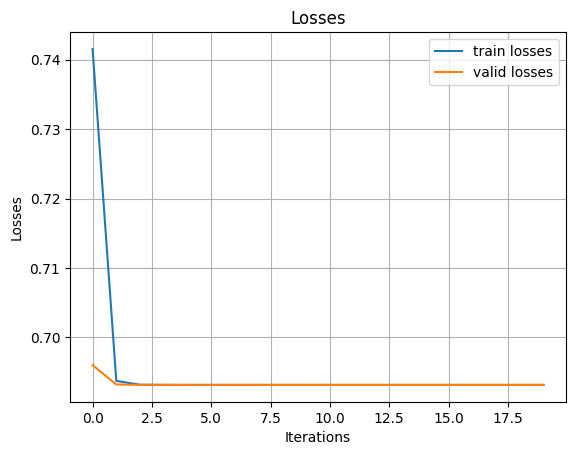

In [ ]:
num_epochs = 20
train_losses = []
valid_losses = []
tl_b = []
accuracyz = []

start = time.time()
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    contact_model.train()

    for i, samples in enumerate(dataloader_train):
        tactiles = samples['tactile'].float().to(device)
        contacts = samples['contact'].float().to(device)

        # Forward pass
        output = contact_model(tactiles)

        # Compute contact loss
        loss = contact_criterion(output, contacts)

        # Backward pass and optimization
        contact_optimizer.zero_grad()
        loss.backward()
        contact_optimizer.step()

        train_loss += loss.item()
        tl_b.append(loss.item())

    train_losses.append(train_loss / len(dataloader_train))

    valid_loss = 0
    accuracy= 0
    contact_model.eval()

    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):
            tactiles = samples['tactile'].float().to(device)
            contacts = samples['contact'].float().to(device)

            # Forward pass
            output = contact_model(tactiles)

            # Compute contact loss
            loss = contact_criterion(output, contacts)

            valid_loss += loss.item()

            # Calculate accuracy
            accuracy += calculate_accuracy(output, contacts)
            accuracyz.append(accuracy)
    valid_losses.append(valid_loss / len(dataloader_valid))

    accuracy /= len(dataloader_valid)

    # Save contact_model with torch.save (if needed)

elapse = time.time() - start
print('Time used (Sec): ', elapse, ' per epoch used: ', elapse / num_epochs , 'Accuracy: ', np.mean(accuracyz))

# plot_losse
plot_losses(train_losses, valid_losses)

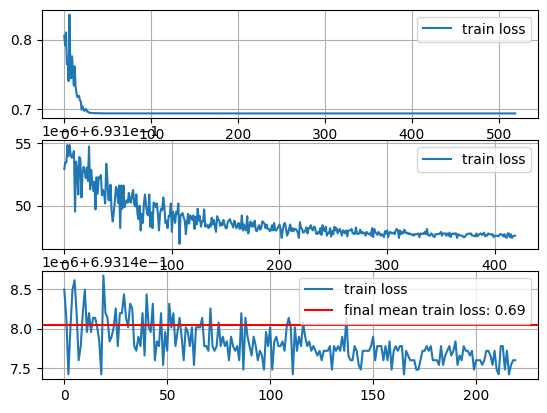

In [ ]:
plt.subplot(311)
plt.plot(tl_b, label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(tl_b[100:], label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(313)
plt.plot(tl_b[300:], label='train loss')
fml = np.mean(tl_b[-320:])
plt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))
plt.grid(True)
plt.legend()

> 

<ipython-input-47-bb3c9a8745dd>:12: UserWarning: Using a target size (torch.Size([32, 3, 1, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  criterion = F.mse_loss(pred, target)
<ipython-input-47-bb3c9a8745dd>:12: UserWarning: Using a target size (torch.Size([12, 3, 1, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  criterion = F.mse_loss(pred, target)
<ipython-input-47-bb3c9a8745dd>:12: UserWarning: Using a target size (torch.Size([11, 3, 1, 1])) that is different to the input size (torch.Size([11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  criterion = F.mse_loss(pred, target)


> > > > > > > > > > > > > > > > > > > Time used (Sec):  257.43023777008057  per epoch used:  12.871511888504028 Accuracy :  9.058037781289645


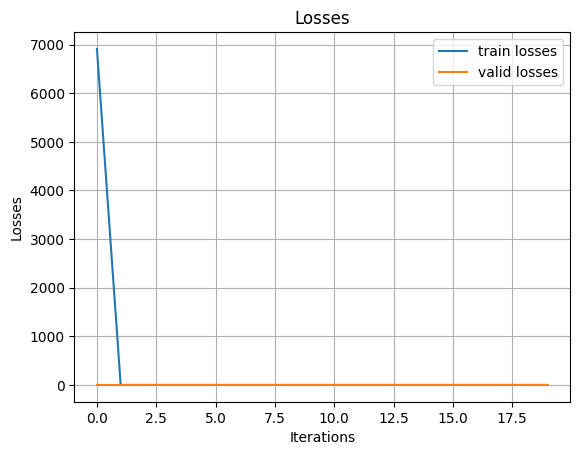

In [ ]:

## Tactile Depth Model
train_losses_, valid_losses_ = [], []
tl_b_ = []
accuracyz = []
start = time.time()
for epoch in range(num_epochs):
    print('>', end=' ')

    train_loss = 0
    tactile_depth_model.train()
    for i, samples in enumerate(dataloader_train):
        tactiles = samples['tactile'].float().to(device)
        depths = samples['depth'].float().to(device)

        tactile_depth_optimizer.zero_grad()

        # Forward pass
        output = tactile_depth_model(tactiles, depths)

        # Compute loss
        depths_specific = depths[:, :, 1, 1].unsqueeze(-1).unsqueeze(-1)
        outputz = output.squeeze(dim=-1).squeeze(dim=-1)
        depths_specificz = depths_specific.squeeze()
        loss = tactile_depth_criterion(output, depths_specific)

        # Backward pass
        loss.backward()

        # Optimization
        tactile_depth_optimizer.step()

        train_loss += loss.item()
        tl_b_.append(loss.item())

    train_losses_.append(train_loss / len(dataloader_train))

    valid_loss = 0
    tactile_depth_model.eval()
    with torch.no_grad():
        for i, samples in enumerate(dataloader_valid):
            tactiles = samples['tactile'].float().to(device)
            depths = samples['depth'].float().to(device)

            # Forward pass
            output = tactile_depth_model(tactiles, depths)

            # Compute loss
            depths_specific = depths[:, :, 1, 1].unsqueeze(-1).unsqueeze(-1)
            loss = tactile_depth_criterion(output, depths_specific)
            valid_loss += loss.item()
            # Calculate accuracy
            accuracy += calculate_accuracy(output, depths_specific)
            accuracyz.append(accuracy)
    valid_losses_.append(valid_loss / len(dataloader_valid))

    # Save tactile_depth_model with torch.save if needed

elapse = time.time() - start
print('Time used (Sec): ', elapse, ' per epoch used: ', elapse / num_epochs, 'Accuracy : ', np.mean(accuracyz))
plot_losses(train_losses_, valid_losses_)

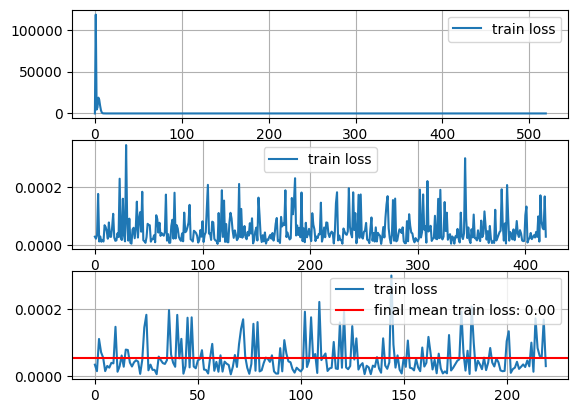

In [ ]:
plt.subplot(311)
plt.plot(tl_b_, label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(tl_b_[100:], label='train loss')
plt.grid(True)
plt.legend()

plt.subplot(313)
plt.plot(tl_b_[300:], label='train loss')
fml = np.mean(tl_b_[-320:])
plt.axhline(y = fml, color='r', linestyle='-', label='final mean train loss: {:.2f}'.format(fml))
plt.grid(True)
plt.legend()

Evaluation of the Model

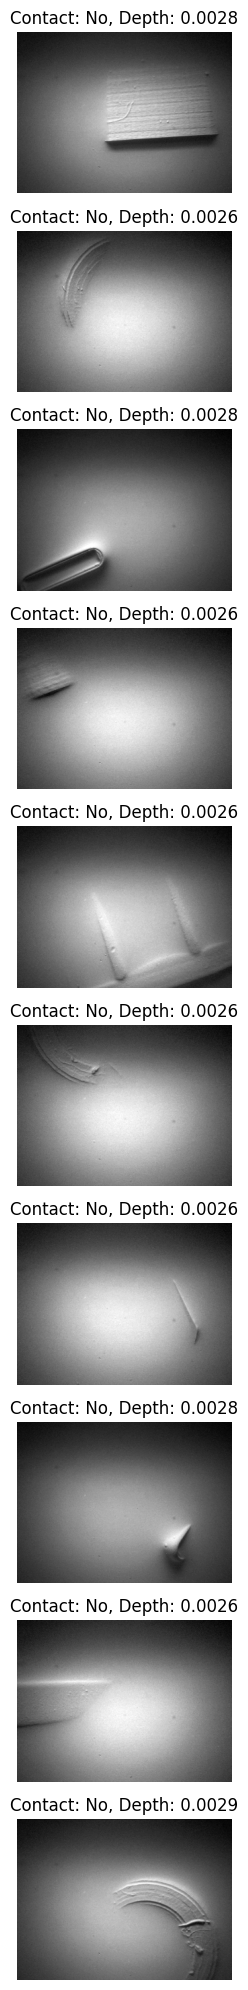

In [ ]:
outputs = []
# Loop through the validation data
for i, samples in enumerate(dataloader_valid):
    tactiles = samples['tactile'].float().to(device)
    depths = samples['depth'].float().to(device)
    contacts = samples['contact'].float().to(device)

    # Results from contact network
    contact_model.eval()
    tactile_depth_model.eval()

    with torch.no_grad():
        contact_output = contact_model(tactiles)
        depth_output = tactile_depth_model(tactiles, depths)  # Predict depth

    # Classify contact based on output value
    predicted_contact = (torch.sigmoid(contact_output) > 0).float()  # Thresholding at 0 Change if otherwise.

    # Store the outputs and predictions
    outputs.append((tactiles, contacts, predicted_contact, depth_output))

    # Visualize 10 sample images
    if i < 10:
        fig, axes = plt.subplots(10, 1, figsize=(5, 20))

        # ... (previous code remains unchanged)

        for j in range(10):

           # Plot original tactile image
           original_image = tactiles[j].cpu().numpy()[0]  # Assuming grayscale
           original_image = original_image.reshape(240, 320)

           axes[j].imshow(original_image, cmap='gray')

           # Check if contact is predicted and display information for each sample
           total_elements = predicted_contact[j].numel()  # Total number of elements
           elements_below_threshold = (predicted_contact[j] < 0).sum().item()  # Count elements below 0 # Thresholding at 0 Change if otherwise.

           # Calculate the ratio of elements below the threshold to the total elements
           ratio_below_threshold = elements_below_threshold / total_elements

           # Check if more than 50% of elements are below 0.5 threshold Change if otherwise.
           is_contact = 'Yes' if ratio_below_threshold > 0.5 else 'No'

           # Get depth value
           depth_value = depth_output[j].item()  # Get the depth value directly

           # Set the title with contact prediction and depth value
           axes[j].set_title(f"Contact: {is_contact}, Depth: {depth_value:.4f}")
           axes[j].axis('off')


        plt.tight_layout()
        plt.show()
        break  # Break after visualizing the first 10 samples

Define a function below that instantializes the networks again and loads the weights for new predictions. This function will be used for testing purposes.

In [ ]:
def predict(tactile_image):
    # Instantiate contact model
    contact_model = ContactNet()

    # Instantiate tactile depth model
    tactile_depth_model = TactileDepthNet()
     # process tactile_image

     #custom dataset transformation
    data_transform = transforms.Compose([
        transforms.Resize((240, 320)),
        transforms.ToTensor(),
    ])

    # Open and preprocess the image using the same transformation as in the dataset
    image_tensor = Image.open(tactile_image).convert('RGB')
    image_tensor = data_transform(img).unsqueeze(0)
    # Get predictions from models
    with torch.no_grad():
        contact_output = contact_model(image_tensor)
        depth_output = tactile_depth_model(image_tensor)

    # Process contact prediction
    contact = 'Contact' if torch.sigmoid(contact_output) > 0.5 else 'No Contact'

    # Process depth prediction (assuming depth_output is in pixel values)
    depth = depth_output.item()  # Getting the depth value in pixels

    return contact, depth

Refrences:

[1] [Depth Map Prediction from a Single Image
using a Multi-Scale Deep Network](https://arxiv.org/pdf/1406.2283.pdf)

[2] [MidasTouch: Monte-Carlo inference over
distributions across sliding touch](https://arxiv.org/pdf/2210.14210.pdf)

[3] [depth-eigen](https://github.com/shuuchen/depth_eigen/tree/master)
